# Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
area = pd.read_csv('la.area', delimiter='\t')
un = pd.read_csv('la.data.65.City', delimiter='\t')
un.columns = un.columns.str.strip()
un['value'] = pd.to_numeric(un['value'], errors='coerce')
un['series_id'] = un['series_id'].str.strip()
filtered_data = un[un['series_id'].str.endswith('03', na=False)]

/var/folders/ll/bdsd7zmj3zgg4132tg87rls80000gn/T/ipykernel_1037/4057716174.py:5: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  un = pd.read_csv('la.data.65.City', delimiter='\t')


In [2]:
filtered_data=filtered_data[filtered_data['year']>=2000]
filtered_data['area_code'] = filtered_data['series_id'].str[3:18]
area_entry = area.loc[area['area_code'] == 'CT5645050000000']
unemp = pd.merge(filtered_data, area, on='area_code', how='inner')
unemp['area_text'] = unemp['area_text'].str.replace(' city,', ',', regex=True)
unemp['area_text'] = unemp['area_text'].str.replace(' town,', ',', regex=True)
labor = pd.read_csv('City_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv')
# Rename the columns in the labor DataFrame to remove the last three characters for the date columns
labor.columns = [col[:-3] if col[-1].isdigit() and len(col) == 10 else col for col in labor.columns]

In [3]:
# Remove rows where 'period' contains 'M13'
unemp = unemp[~unemp['period'].str.contains('M13')]
# Reset index after filtering
unemp.reset_index(drop=True, inplace=True)
print("Rows with 'M13' removed successfully!")

Rows with 'M13' removed successfully!


In [4]:
# Find unique city-state combinations in both datasets
unemp_city_states = set(unemp['area_text'].unique())
labor_city_states = set(labor['RegionName'] + ', ' + labor['State'])

# Identify mismatched city-state pairs
mismatched = unemp_city_states - labor_city_states

print("Mismatched city-state pairs:")
print(mismatched)

Mismatched city-state pairs:
{'Ocean township (Monmouth County), NJ', 'Roxbury, ME', 'St. Cloud, FL', 'Wallagrass, ME', 'Washington charter township (Macomb County), MI', 'Washington township (Gloucester County), NJ', 'Hamburg, NY', 'Norwalk city/town, CT', 'Maplewood township, NJ', 'North Attleborough Town, MA', 'Westmont village, IL', 'Hallandale Beach, FL', 'Arlington Heights village, IL', 'Macomb township, MI', 'Stockholm, ME', 'Berkeley township, NJ', 'St. George, VT', 'Knox, ME', 'Warminster township, PA', 'Upper Dublin township, PA', 'Egg Harbor township, NJ', 'Commerce charter township, MI', 'Honolulu County/city, HI', 'Littleton, ME', 'New Limerick, ME', 'Blaine, ME', 'Sayreville borough, NJ', 'Piscataway township, NJ', 'St. Peters, MO', 'Menomonee Falls village, WI', 'Lower Paxton township, PA', 'Montgomery township (Montgomery County), PA', 'Central Aroostook unorganized, ME', 'Bloomfield charter township (Oakland County), MI', 'Weymouth Town, MA', 'Grand Blanc charter towns

In [5]:
# Drop rows with mismatched city-state pairs
unemp = unemp[unemp['area_text'].isin(labor_city_states)]
print("Rows with unmatched city-state pairs removed successfully.")

Rows with unmatched city-state pairs removed successfully.


In [8]:
def get_city_month_value(row):
    city, state = row['area_text'].split(', ')
    year = row['year']
    month = row['period'][1:]  # Remove the 'M' from the period to get the month
    date_str = f"{year}-{int(month):02d}"

    filtered = labor.loc[(labor['RegionName'] == city) & (labor['State'] == state), date_str]
    return filtered.values[0]


# Apply the function
unemp['city_month_value'] = unemp.apply(get_city_month_value, axis=1)

In [7]:
unemp.shape

(794274, 11)

# Baseline models

In [67]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense


# Prepare the data
def create_dataset(data, area_text, look_back=5):
    skips = 0
    if len(data) != len(area_text):
        raise ValueError('The data and area_text arrays must have the same length')
    X, Y = [], []
    for i in range(len(data) - look_back):
        if(area_text[i] != area_text[i+look_back]):
            skips+=1
            continue
        a = data[i:(i + look_back), 0]
        b = data[i:(i + look_back), 1]
        X.append(np.concatenate((a, b)))
        Y.append(data[i + look_back, 0])

    print(f"Skipped {skips} entries")
    print(f"{len(data)} -> {len(X)}")
    return np.array(X), np.array(Y)

unemp = unemp.head(100000)
# # Split the data into training and testing sets
# train_data = unemp[unemp['year'] < 2022]
# test_data = unemp[unemp['year'] >= 2022]
train_data = unemp.iloc[:80000]
test_data = unemp.iloc[80000:]

# Extract the relevant columns for training and testing
train_data = train_data[['city_month_value', 'value','area_text']].dropna()
test_data = test_data[['city_month_value', 'value','area_text']].dropna()

# Get the values for training and testing
train_values = train_data[['city_month_value', 'value']].values
test_values = test_data[['city_month_value', 'value']].values
train_area_text = train_data['area_text'].values
test_area_text = test_data['area_text'].values

# Normalize the datasets
scaler = MinMaxScaler(feature_range=(0, 1))
train_values = scaler.fit_transform(train_values)
test_values = scaler.transform(test_values)

# Create the dataset for LSTM
look_back = 5
X_train, Y_train = create_dataset(train_values, train_area_text, look_back)
X_test, Y_test = create_dataset(test_values, test_area_text, look_back)

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], look_back, 2))
X_test = np.reshape(X_test, (X_test.shape[0], look_back, 2))

Skipped 1335 entries
55598 -> 54258
Skipped 335 entries
12259 -> 11919


In [69]:
from sklearn.metrics import mean_squared_error
def naive_predict(sample):
    return 2*sample[-1, 0]-sample[-2, 0]
# Calculate the MSE for the baseline model (using the last month's value as prediction)
baseline_predictions = X_test[:, -1, 0]  # Use the last month's value from the input sequence
baseline_mse = mean_squared_error(Y_test/scaler.scale_[0], baseline_predictions/scaler.scale_[0])

baseline_prediction2 = np.array([naive_predict(sample) for sample in X_test])
baseline_mse2 = mean_squared_error(Y_test/scaler.scale_[0], baseline_prediction2/scaler.scale_[0])

print(f"Baseline Model RMSE: {baseline_mse ** 0.5}")
print(f"Baseline Model 2 RMSE: {baseline_mse2 ** 0.5}")

Baseline Model RMSE: 392459.97110304865
Baseline Model 2 RMSE: 441400.6473083381


# ARIMA

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.preprocessing import MinMaxScaler

# Step 1: Load the dataset
data = pd.read_csv('all city.csv')

# Step 2: Inspect and clean the 'period' column
print("Unique values in 'period':", data['period'].unique())

# Filter for valid months (M01 to M12)
valid_months = [f"M{str(i).zfill(2)}" for i in range(1, 13)]
data = data[data['period'].isin(valid_months)]

# Step 3: Create a Date column
data['Date'] = pd.to_datetime(data['year'].astype(str) + '-' + data['period'].str[1:], format='%Y-%m')

# Step 4: Aggregate data by Date
aggregated_data = data.groupby('Date')['city_month_value'].mean()

# Step 5: Normalize the data using MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
normalized_data = scaler.fit_transform(aggregated_data.values.reshape(-1, 1)).flatten()

# Convert back to a pandas Series for compatibility
normalized_data = pd.Series(normalized_data, index=aggregated_data.index)

Unique values in 'period': ['M01' 'M02' 'M03' 'M04' 'M05' 'M06' 'M07' 'M08' 'M09' 'M10' 'M11' 'M12'
 'M13']


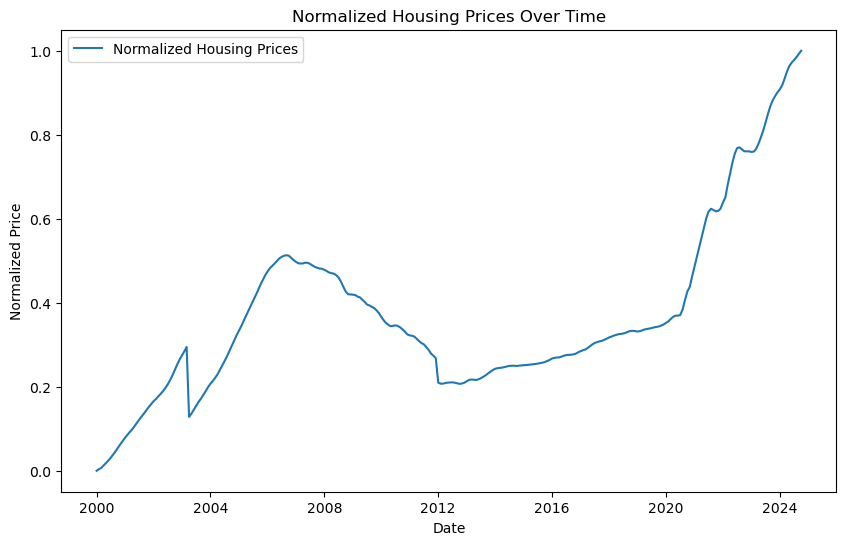

In [2]:
# Step 6: Plot the normalized time series
plt.figure(figsize=(10, 6))
plt.plot(normalized_data, label="Normalized Housing Prices")
plt.title("Normalized Housing Prices Over Time")
plt.xlabel("Date")
plt.ylabel("Normalized Price")
plt.legend()
plt.show()

In [3]:
# Step 7: Determine the value of d using the ADF test
def check_stationarity(series):
    result = adfuller(series, autolag='AIC')
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    print("Critical Values:", result[4])
    return result[1] < 0.05  # Return True if the series is stationary

# Iteratively apply differencing and determine d
series = normalized_data
d = 0
while not check_stationarity(series):
    series = series.diff().dropna()
    d += 1
    print(f"Applied differencing {d} times.")
print(f"Determined value of d: {d}")


ADF Statistic: 0.8207611462644234
p-value: 0.9919640070901894
Critical Values: {'1%': -3.452789844280995, '5%': -2.871421512222641, '10%': -2.5720351510944512}
Applied differencing 1 times.
ADF Statistic: -6.900669991012571
p-value: 1.2845146532070524e-09
Critical Values: {'1%': -3.452789844280995, '5%': -2.871421512222641, '10%': -2.5720351510944512}
Determined value of d: 1


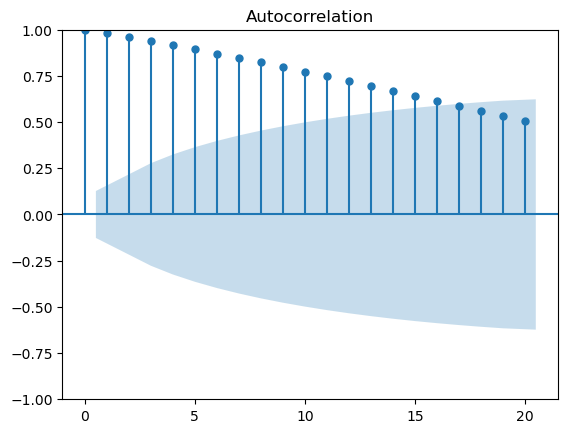

/Users/lihengzhou/anaconda3/lib/python3.11/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


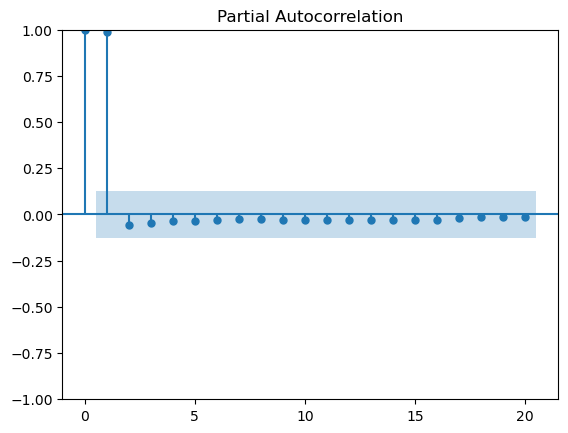

In [4]:
# Step 8: Train-Test Split
split_ratio = 0.8
train_size = int(len(normalized_data) * split_ratio)
train, test = normalized_data[:train_size], normalized_data[train_size:]

# Step 9: Plot ACF and PACF for parameter selection
plot_acf(train, lags=20)
plt.show()
plot_pacf(train, lags=20)
plt.show()

/Users/lihengzhou/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/lihengzhou/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/lihengzhou/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Root Mean Squared Error (RMSE) on Original Scale: 91252.10177104404


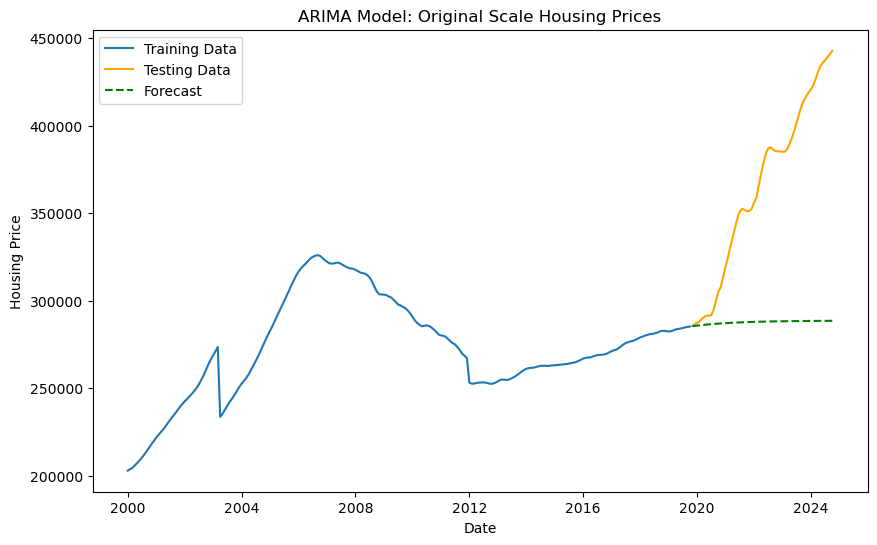

In [5]:
# ARIMA Parameters
p, d, q = 2, 1, 1  # Adjust based on ACF/PACF results

# Step 10: Fit ARIMA Model with the determined d
arima_model = ARIMA(train, order=(p, d, q))
arima_result = arima_model.fit()

# Step 11: Forecast on Test Data (Normalized)
forecast_normalized = arima_result.forecast(steps=len(test))

# Step 12: Inverse Transform the Forecast and Test Data
# Convert forecasts back to the original scale
forecast_original = scaler.inverse_transform(forecast_normalized.values.reshape(-1, 1)).flatten()
test_original = scaler.inverse_transform(test.values.reshape(-1, 1)).flatten()

# Step 13: Evaluate Model Performance on Original Scale
rmse_original = sqrt(mean_squared_error(test_original, forecast_original))
print(f"Root Mean Squared Error (RMSE) on Original Scale: {rmse_original}")

# Step 14: Plot Training, Testing, and Forecast Data (Original Scale)
plt.figure(figsize=(10, 6))
plt.plot(aggregated_data[:train_size], label="Training Data")
plt.plot(aggregated_data[train_size:], label="Testing Data", color='orange')
plt.plot(test.index, forecast_original, label="Forecast", color='green', linestyle='--')
plt.title("ARIMA Model: Original Scale Housing Prices")
plt.xlabel("Date")
plt.ylabel("Housing Price")
plt.legend()
plt.show()



# RNN

43406/43406 - 36s - loss: 3.4889e-04 - val_loss: 1.9847e-05 - 36s/epoch - 832us/step
Epoch 1/20
3392/3392 [==============================] - 5s 1ms/step - loss: 1.1657e-05 - val_loss: 1.2386e-05
Epoch 2/20
3392/3392 [==============================] - 5s 1ms/step - loss: 8.7537e-06 - val_loss: 5.9142e-06
Epoch 3/20
3392/3392 [==============================] - 5s 1ms/step - loss: 9.5247e-06 - val_loss: 1.9930e-06
Epoch 4/20
3392/3392 [==============================] - 5s 1ms/step - loss: 8.5671e-06 - val_loss: 1.5465e-06
Epoch 5/20
3392/3392 [==============================] - 5s 1ms/step - loss: 8.2490e-06 - val_loss: 5.7006e-06
Epoch 6/20
3392/3392 [==============================] - 5s 1ms/step - loss: 8.0067e-06 - val_loss: 1.2401e-06
Epoch 7/20
3392/3392 [==============================] - 5s 1ms/step - loss: 7.7716e-06 - val_loss: 7.3730e-06
Epoch 8/20
3392/3392 [==============================] - 5s 1ms/step - loss: 6.9459e-06 - val_loss: 6.8001e-06
Epoch 9/20
3392/3392 [=============

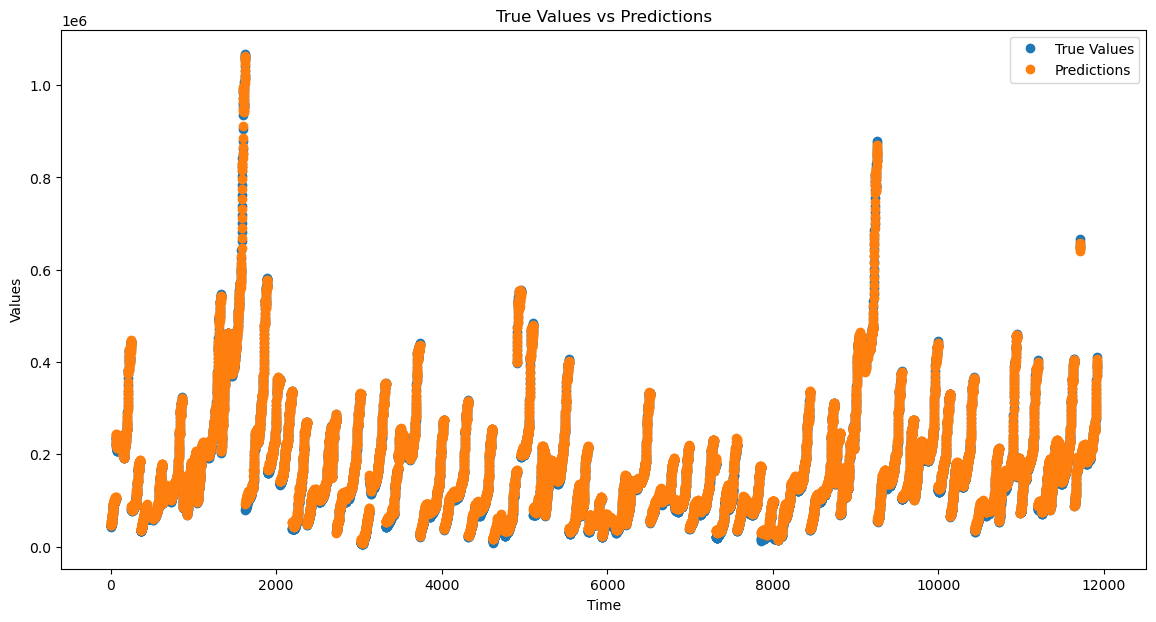

In [70]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense

model = Sequential()
model.add(SimpleRNN(50, return_sequences=True, input_shape=(look_back, 2)))
model.add(SimpleRNN(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

model.fit(X_train, Y_train, epochs=1, batch_size=1, verbose=2, validation_split=0.2)

model.fit(X_train, Y_train, epochs=20, batch_size=16, validation_data=(X_test, Y_test), verbose=1)
rnnpred = model.predict(X_test)
rnnpred=rnnpred.reshape(-1)
plt.figure(figsize=(14, 7))
plt.plot(Y_test/scaler.scale_[0], 'o', label='True Values')
plt.plot(rnnpred/scaler.scale_[0], 'o', label='Predictions')
plt.title('True Values vs Predictions')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()

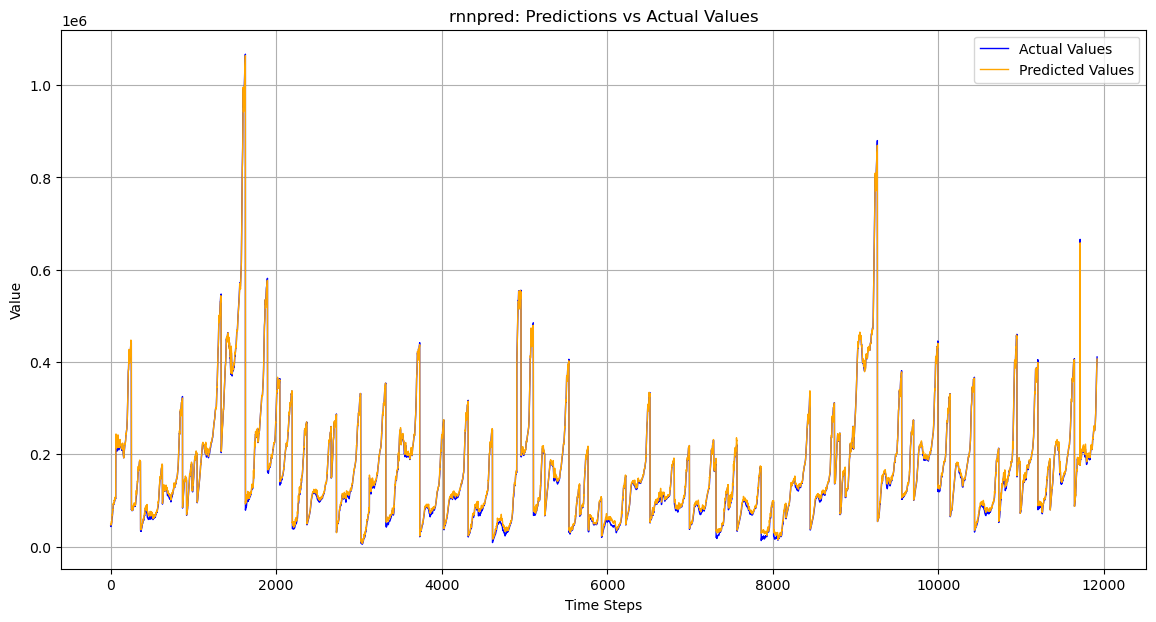

In [71]:
plt.figure(figsize=(14, 7))

# Plot the actual values as a line
plt.plot(Y_test/scaler.scale_[0], label='Actual Values', color='blue', linewidth=1)

# Plot the predicted values as a line
plt.plot(rnnpred/scaler.scale_[0], label='Predicted Values', color='orange', linewidth=1)

# Add titles, axis labels, and a legend
plt.title('rnnpred: Predictions vs Actual Values')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()

# Show the grid and the plot
plt.grid(True)
plt.show()

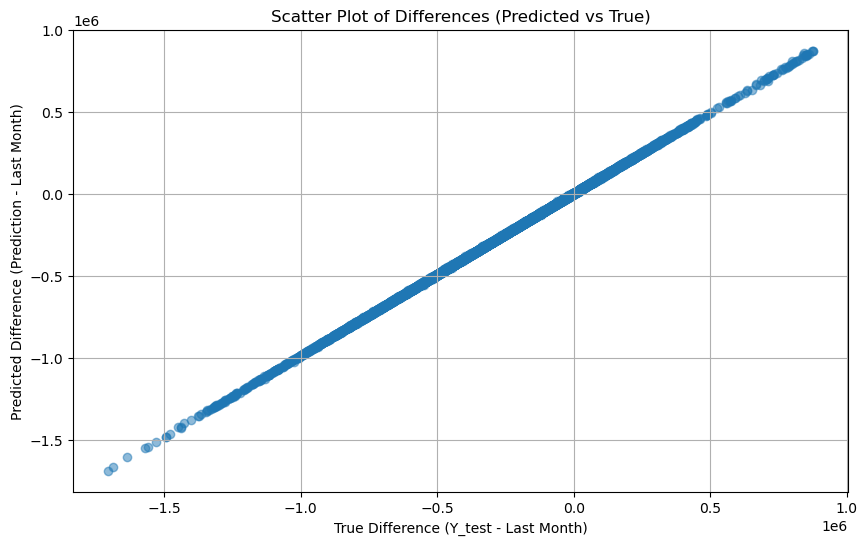

In [72]:
# Calculate the differences
predicted_diff = rnnpred- X_test[:, -1, 0]
true_diff = Y_test - X_test[:, -1, 0]

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(true_diff/scaler.scale_[0], predicted_diff/scaler.scale_[0], alpha=0.5)
plt.title('Scatter Plot of Differences (Predicted vs True)')
plt.xlabel('True Difference (Y_test - Last Month)')
plt.ylabel('Predicted Difference (Prediction - Last Month)')
plt.grid(True)
plt.show()

In [73]:
rnn_mse = mean_squared_error(Y_test/scaler.scale_[0], rnnpred/scaler.scale_[0])
print(f"RNN Model RMSE: {rnn_mse** 0.5}")

RNN Model RMSE: 4821.022499225791


# LSTM

In [74]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 2)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model.fit(X_train, Y_train, epochs=1, batch_size=1, verbose=2,validation_split=0.8)

10851/10851 - 31s - loss: 4.1439e-04 - val_loss: 5.6854e-05 - 31s/epoch - 3ms/step


In [85]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Build the LSTM model
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(look_back, 2)))  # Increased LSTM units
model.add(Dropout(0.2))  # Dropout for regularization
model.add(LSTM(64))  # Increased LSTM units
model.add(Dropout(0.2))  # Dropout for regularization
model.add(Dense(1))  # Output layer
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)

# Train the model
history = model.fit(
    X_train, Y_train,
    epochs=50,  # Increased epochs for better learning
    batch_size=32,  # Larger batch size
    validation_split=0.2,  # Use 20% of training data for validation
    verbose=2,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the model
test_loss, test_mse = model.evaluate(X_test, Y_test, verbose=2)
print(f"Test Loss: {test_loss}, Test MSE: {test_mse}")

Epoch 1/50
1357/1357 - 5s - loss: 4.7452e-04 - mse: 4.7452e-04 - val_loss: 4.6733e-05 - val_mse: 4.6733e-05 - lr: 0.0010 - 5s/epoch - 3ms/step
Epoch 2/50
1357/1357 - 3s - loss: 1.6379e-04 - mse: 1.6379e-04 - val_loss: 2.6154e-05 - val_mse: 2.6154e-05 - lr: 0.0010 - 3s/epoch - 3ms/step
Epoch 3/50
1357/1357 - 3s - loss: 1.2544e-04 - mse: 1.2544e-04 - val_loss: 4.5114e-05 - val_mse: 4.5114e-05 - lr: 0.0010 - 3s/epoch - 3ms/step
Epoch 4/50
1357/1357 - 3s - loss: 1.3353e-04 - mse: 1.3353e-04 - val_loss: 4.9037e-05 - val_mse: 4.9037e-05 - lr: 0.0010 - 3s/epoch - 3ms/step
Epoch 5/50
1357/1357 - 3s - loss: 1.1141e-04 - mse: 1.1141e-04 - val_loss: 1.7617e-05 - val_mse: 1.7617e-05 - lr: 5.0000e-04 - 3s/epoch - 3ms/step
Epoch 6/50
1357/1357 - 3s - loss: 1.0464e-04 - mse: 1.0464e-04 - val_loss: 2.0992e-05 - val_mse: 2.0992e-05 - lr: 5.0000e-04 - 3s/epoch - 3ms/step
Epoch 7/50
1357/1357 - 3s - loss: 1.1222e-04 - mse: 1.1222e-04 - val_loss: 3.7120e-05 - val_mse: 3.7120e-05 - lr: 5.0000e-04 - 3s/epoc

In [75]:
lstm_predictions = model.predict(X_test)
# predictions_with_zeros = np.concatenate([lstm_predictions, np.zeros_like(lstm_predictions)], axis=1)
# lstm_invtransfromed_pred = scaler.inverse_transform(predictions_with_zeros)[:, 0]
# Y_test_invtransfromed = scaler.inverse_transform(np.concatenate([Y_test.reshape(-1,1), np.zeros((Y_test.shape[0],1))], axis=1))[:, 0]
lstm_predictions = lstm_predictions.reshape(-1)

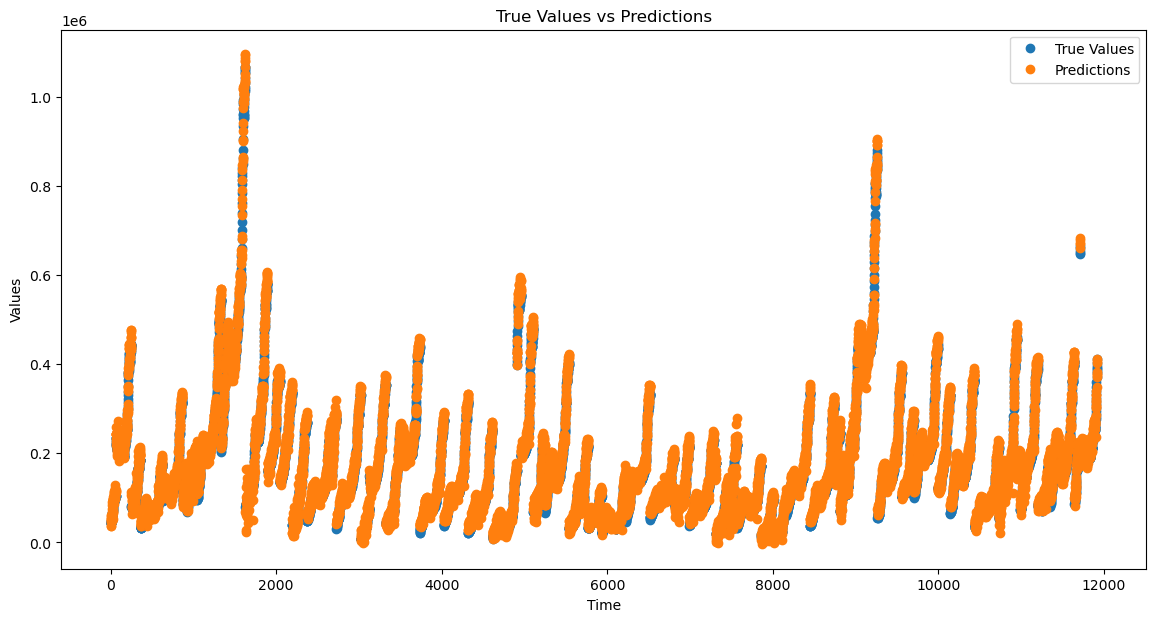

In [86]:
plt.figure(figsize=(14, 7))
plt.plot(Y_test/scaler.scale_[0], 'o', label='True Values')
plt.plot(lstm_predictions/scaler.scale_[0], 'o', label='Predictions')
plt.title('True Values vs Predictions')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()

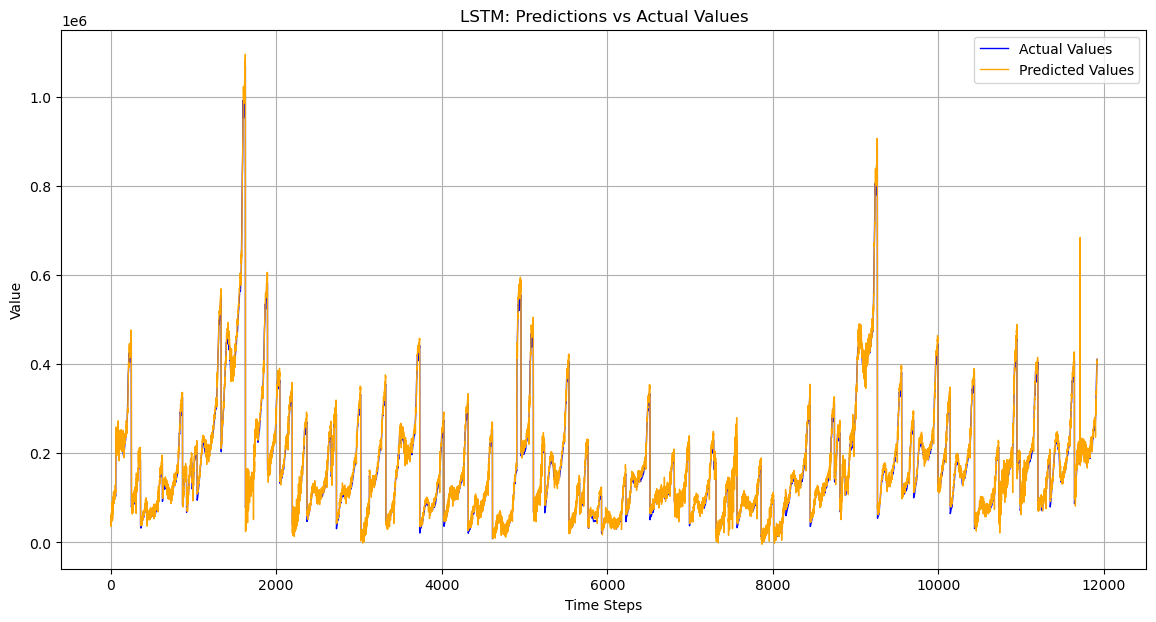

In [87]:
plt.figure(figsize=(14, 7))

# Plot the actual values as a line
plt.plot(Y_test/scaler.scale_[0], label='Actual Values', color='blue', linewidth=1)

# Plot the predicted values as a line
plt.plot(lstm_predictions/scaler.scale_[0], label='Predicted Values', color='orange', linewidth=1)

# Add titles, axis labels, and a legend
plt.title('LSTM: Predictions vs Actual Values')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()

# Show the grid and the plot
plt.grid(True)
plt.show()

In [92]:
predicted_diff.shape, true_diff.shape

((11919, 11919), (11919,))

In [89]:
# Calculate the MSE for the LSTM model's predictions
lstm_predictions = model.predict(X_test)
lstm_mse = mean_squared_error(Y_test/scaler.scale_[0], lstm_predictions/scaler.scale_[0])
print(f"LSTM Model RMSE: {lstm_mse**0.5}")

LSTM Model RMSE: 7938.473521097747


# LSTM with Attention

In [80]:
from keras.models import Model
from keras.layers import Input, Attention, Flatten
from keras.callbacks import EarlyStopping

# Function to create the dataset with time steps
def create_dataset_with_area(data, area_text, look_back=5):
    skips = 0
    if len(data) != len(area_text):
        raise ValueError('The data and area_text arrays must have the same length')
    X, Y = [], []
    for i in range(len(data) - look_back):
        # Ensure the area remains the same for the sequence
        if area_text[i] != area_text[i + look_back]:
            skips += 1
            continue
        X.append(data[i:(i + look_back)])
        Y.append(data[i + look_back, 0])  # Predict the first feature (e.g., city_month_value)

    print(f"Skipped {skips} entries due to mismatched areas.")
    print(f"Generated {len(X)} sequences from {len(data)} records.")
    return np.array(X), np.array(Y)

# Define the LSTM + Attention Model
input_layer = Input(shape=(look_back, X_train.shape[2]))
lstm_out = LSTM(50, return_sequences=True)(input_layer)
attention_out = Attention()([lstm_out, lstm_out])  # Attention applied here
flatten_out = Flatten()(attention_out)
output = Dense(1)(flatten_out)

model = Model(inputs=input_layer, outputs=output)
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mse'])

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model.fit(
    X_train, Y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=2,
    callbacks=[early_stopping]
)

# Evaluate the model
loss, mse = model.evaluate(X_test, Y_test, verbose=2)
print(f"Test Loss: {loss}, Test MAE: {mse}")

# Make predictions
Y_pred = model.predict(X_test)

Epoch 1/50


2024-12-16 11:31:47.689474: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "108" frequency: 2400 num_cores: 8 environment { key: "cpu_instruction_set" value: "SSE, SSE2, SSE3, SSSE3" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 131072 l2_cache_size: 8388608 l3_cache_size: 2097152 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


1357/1357 - 2s - loss: 3.6196e-04 - mse: 3.6196e-04 - val_loss: 4.1213e-05 - val_mse: 4.1213e-05 - 2s/epoch - 2ms/step


2024-12-16 11:31:49.550845: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "108" frequency: 2400 num_cores: 8 environment { key: "cpu_instruction_set" value: "SSE, SSE2, SSE3, SSSE3" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 131072 l2_cache_size: 8388608 l3_cache_size: 2097152 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


Epoch 2/50
1357/1357 - 2s - loss: 4.6940e-05 - mse: 4.6940e-05 - val_loss: 2.2686e-05 - val_mse: 2.2686e-05 - 2s/epoch - 1ms/step
Epoch 3/50
1357/1357 - 2s - loss: 4.3559e-05 - mse: 4.3559e-05 - val_loss: 2.7164e-05 - val_mse: 2.7164e-05 - 2s/epoch - 1ms/step
Epoch 4/50
1357/1357 - 2s - loss: 4.1979e-05 - mse: 4.1979e-05 - val_loss: 2.3366e-05 - val_mse: 2.3366e-05 - 2s/epoch - 1ms/step
Epoch 5/50
1357/1357 - 2s - loss: 3.8361e-05 - mse: 3.8361e-05 - val_loss: 4.0823e-05 - val_mse: 4.0823e-05 - 2s/epoch - 1ms/step
Epoch 6/50
1357/1357 - 2s - loss: 3.8469e-05 - mse: 3.8469e-05 - val_loss: 1.7173e-05 - val_mse: 1.7173e-05 - 2s/epoch - 1ms/step
Epoch 7/50
1357/1357 - 2s - loss: 3.4183e-05 - mse: 3.4183e-05 - val_loss: 2.7169e-05 - val_mse: 2.7169e-05 - 2s/epoch - 1ms/step
Epoch 8/50
1357/1357 - 2s - loss: 3.0931e-05 - mse: 3.0931e-05 - val_loss: 1.5315e-05 - val_mse: 1.5315e-05 - 2s/epoch - 1ms/step
Epoch 9/50
1357/1357 - 2s - loss: 2.7673e-05 - mse: 2.7673e-05 - val_loss: 1.4911e-05 - va

2024-12-16 11:32:31.823255: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:689] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "108" frequency: 2400 num_cores: 8 environment { key: "cpu_instruction_set" value: "SSE, SSE2, SSE3, SSSE3" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 131072 l2_cache_size: 8388608 l3_cache_size: 2097152 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


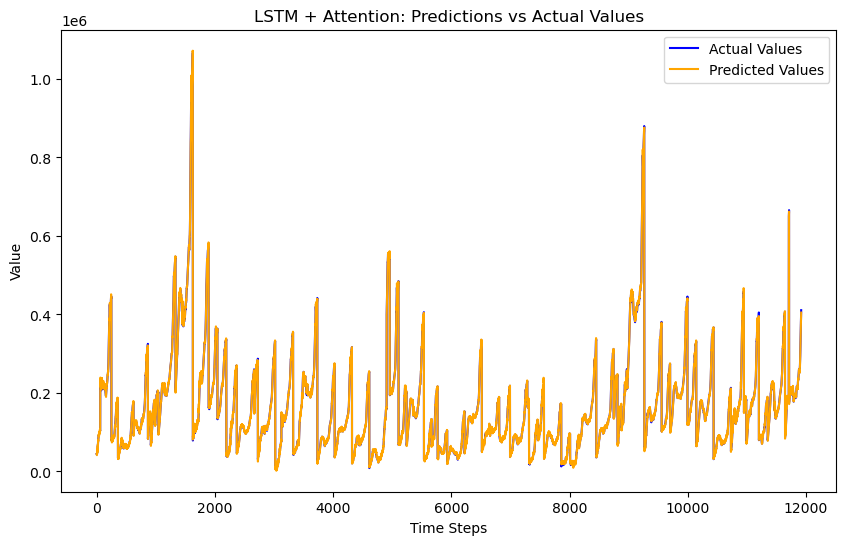

In [81]:
plt.figure(figsize=(10, 6))
plt.plot(Y_test/scaler.scale_[0], label="Actual Values", color="blue")
plt.plot(Y_pred/scaler.scale_[0], label="Predicted Values", color="orange")
plt.xlabel("Time Steps")
plt.ylabel("Value")
plt.title("LSTM + Attention: Predictions vs Actual Values")
plt.legend()
plt.show()

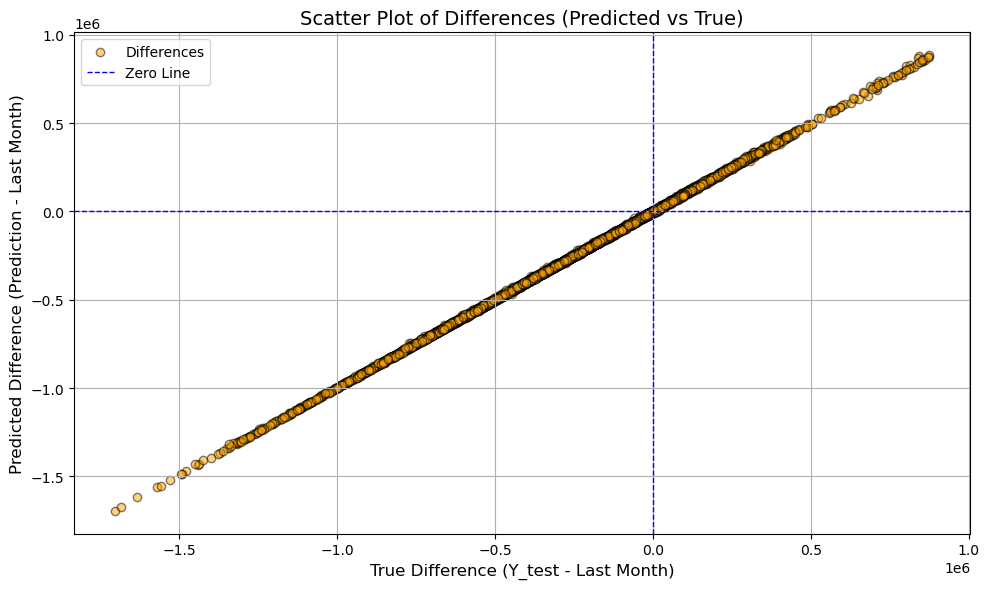

In [82]:
# Calculate the differences
predicted_diff = Y_pred.flatten() - X_test[:, -1, 0]  # Prediction minus the last time step
true_diff = Y_test - X_test[:, -1, 0]  # Actual value minus the last time step

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(true_diff/scaler.scale_[0], predicted_diff/scaler.scale_[0], alpha=0.5, c='orange', edgecolor='k', label='Differences')
plt.axhline(0, color='blue', linestyle='--', linewidth=1, label='Zero Line')  # Horizontal zero line
plt.axvline(0, color='blue', linestyle='--', linewidth=1)  # Vertical zero line
plt.title('Scatter Plot of Differences (Predicted vs True)', fontsize=14)
plt.xlabel('True Difference (Y_test - Last Month)', fontsize=12)
plt.ylabel('Predicted Difference (Prediction - Last Month)', fontsize=12)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [83]:
# Generate predictions for LSTM with Attention
Y_pred = model.predict(X_test)
lstm_attention_mse = mean_squared_error(Y_test/scaler.scale_[0], Y_pred/scaler.scale_[0])
# Print the results
print(f"LSTM with Attention Model RMSE: {lstm_attention_mse**0.5}")

LSTM with Attention Model RMSE: 3465.1507531999296


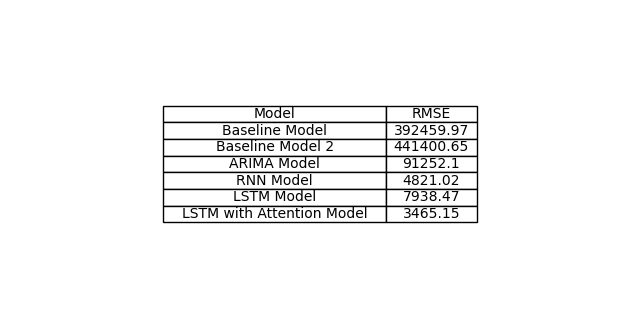

In [9]:
import pandas as pd
# RMSE values (rounded to 2 decimals)
rmse_data = {
    "Model": ["Baseline Model", "Baseline Model 2", "ARIMA Model", "RNN Model", "LSTM Model", "LSTM with Attention Model"],
    "RMSE": [392459.97, 441400.65, 91252.10, 4821.02, 7938.47, 3465.15]
}

# Create a DataFrame
rmse_df = pd.DataFrame(rmse_data)

# Display the table
fig, ax = plt.subplots(figsize=(8, 4))  # Adjust size as needed
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=rmse_df.values, colLabels=rmse_df.columns, cellLoc='center', loc='center')

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(10)
table.auto_set_column_width(col=list(range(len(rmse_df.columns)))) 